In [23]:
def compute_f1_scores(pred_pt, gold_pt, verbose=True):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred = 0, 0, 0

    for i in range(len(pred_pt)):
        n_gold += len(gold_pt[i])
        n_pred += len(pred_pt[i])

        for t in pred_pt[i]:
            if t in gold_pt[i]:
                n_tp += 1

    if verbose:
        print(
            f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}"
        )

    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (
        precision + recall) if precision != 0 or recall != 0 else 0
    scores = {
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'accuracy': n_tp / n_gold * 100
    }

    return scores

def dict_to_list(aspect_list, sentiment_elements):
    tuples = []
    for aspect in aspect_list:
        tuple = []
        for key in sentiment_elements:
            tuple.append(aspect[key])
        tuples.append(tuple)
    return tuples

In [24]:
import json
import numpy as np
f1_scores_all = {}
model = "gemma3_4b"
seeds = ["seed_42", "seed_43"]

for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        
        for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            f1_scores_per_seed = []
            
            # Berechne F1-Score für jeden Seed
            for seed in seeds:
                try:
                    with open(f"./predictions/{seed}/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                       data = json.load(f)
                except FileNotFoundError:
                    continue
                
                sentiment_elements = list(data[0]["gold"][0].keys())
                
                preds = [dict_to_list(example["predicted"], sentiment_elements) for example in data]
                golds = [dict_to_list(example["gold"], sentiment_elements) for example in data]

                scores = compute_f1_scores(preds, golds, verbose=False)
                f1_scores_per_seed.append(scores["f1"])
            
            # Nur fortfahren wenn wir Daten für mindestens einen Seed haben
            if f1_scores_per_seed:
                # Mittelwert über alle verfügbaren Seeds
                avg_f1 = np.mean(f1_scores_per_seed)
                f1_scores.append(avg_f1)
                k_list.append(k)

        f1_scores_all[f"{dataset_name}_{task}"] = {"f1": f1_scores, "k": k_list}

In [25]:
# Calculate average F1 scores across all datasets for each task and k value
f1_scores_avg = {}

for task in ["acd", "tasd", "asqp"]:
    f1_avg = []
    k_avg = []
    
    # Get all k values that have data for this task
    all_k_values = set()
    for dataset in ["rest16", "flightabsa", "coursera", "hotels"]:
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "k" in f1_scores_all[key]:
            all_k_values.update(f1_scores_all[key]["k"])
    
    # Sort k values
    all_k_values = sorted(list(all_k_values))
    
    for k in all_k_values:
        f1_values_for_k = []
        
        # Collect F1 scores for this k value across all datasets
        for dataset in ["rest16", "flightabsa", "coursera", "hotels"]:
            key = f"{dataset}_{task}"
            if key in f1_scores_all and "k" in f1_scores_all[key] and "f1" in f1_scores_all[key]:
                k_list = f1_scores_all[key]["k"]
                f1_list = f1_scores_all[key]["f1"]
                
                # Find the index of this k value
                if k in k_list:
                    idx = k_list.index(k)
                    f1_values_for_k.append(f1_list[idx])
        
        # Calculate average if we have data
        if f1_values_for_k:
            avg_f1 = np.mean(f1_values_for_k)
            f1_avg.append(avg_f1)
            k_avg.append(k)
    
    f1_scores_avg[f"avg_{task}"] = {"f1": f1_avg, "k": k_avg}

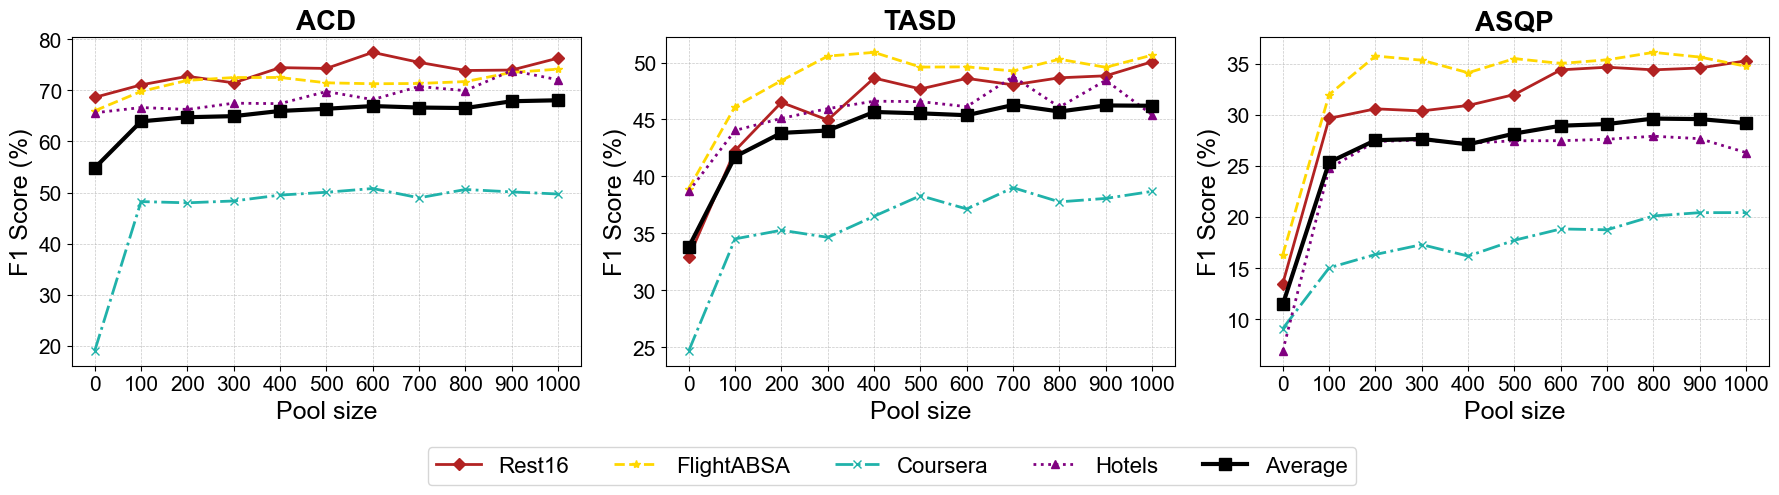

In [34]:
import matplotlib.pyplot as plt

# Set a professional style with Arial font
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Define proper display names for datasets
dataset_display_names = {
    "rest16": "Rest16",
    "flightabsa": "FlightABSA", 
    "coursera": "Coursera",
    "hotels": "Hotels"
}

# Define colors and line styles for better distinction
colors = ['firebrick', 'gold', 'lightseagreen', 'purple']  # Custom colors for datasets
line_styles = ['-', '--', '-.', ':']

# Define markers for each dataset
markers = {
    "rest16": 'D',      # diamond
    "flightabsa": '*',  # star
    "hotels": '^',      # triangle
    "coursera": 'x'     # x
}

for i, task in enumerate(tasks):
    ax = axes[i]
    
    # Plot individual datasets
    for j, dataset in enumerate(datasets):
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "f1" in f1_scores_all[key] and len(f1_scores_all[key]["f1"]) > 0:
            label = dataset_display_names[dataset]
            marker = markers[dataset]
            ax.plot(f1_scores_all[key]["k"], f1_scores_all[key]["f1"], 
                    label=label, color=colors[j], linestyle=line_styles[j], linewidth=2, marker=marker, markersize=6)
    
    # Plot average line
    avg_key = f"avg_{task}"
    if avg_key in f1_scores_avg and "f1" in f1_scores_avg[avg_key] and len(f1_scores_avg[avg_key]["f1"]) > 0:
        ax.plot(f1_scores_avg[avg_key]["k"], f1_scores_avg[avg_key]["f1"], 
                label="Average", color='black', linestyle='-', linewidth=3, marker='s', markersize=8)
    
    # Set ticks for x-axis
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels([f'{int(x * 1000)}' for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
    
    # Add grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'{task.upper()}', fontsize=20, fontweight='bold')
    ax.set_xlabel('Pool size', fontsize=18)
    ax.set_ylabel('F1 Score (%)', fontsize=18)
    
    # Increase tick label size
    ax.tick_params(axis='both', labelsize=15)

# Collect handles and labels for common legend
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates
unique_labels = list(dict.fromkeys(labels))  # Preserve order
unique_labels = ["Rest16", "FlightABSA", "Coursera", "Hotels", "Average"]
unique_handles = [handles[labels.index(label)] for label in unique_labels]

# Add common legend below the plots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=5, fontsize=16, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("performance_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
# Statistische Analyse: Teste ob F1-Scores signifikant mit Poolgröße steigen
from scipy import stats
from statsmodels.stats.multitest import multipletests
import numpy as np

# Sammle p-Werte für alle Task-Dataset-Kombinationen
p_values = []
task_dataset_pairs = []
slopes = []

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

for task in tasks:
    for dataset in datasets:
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "f1" in f1_scores_all[key] and "k" in f1_scores_all[key]:
            k_list = f1_scores_all[key]["k"]
            f1_list = f1_scores_all[key]["f1"]
            
            # Nur fortfahren wenn wir genug Datenpunkte haben
            if len(k_list) >= 3:
                # Lineare Regression: F1 ~ Poolgröße
                slope, intercept, r_value, p_value, std_err = stats.linregress(k_list, f1_list)
                
                # Einseitiger Test: H1: slope > 0 (positive Steigung)
                # Da linregress zweiseitig testet, teilen wir p-value durch 2 für einseitigen Test
                # Aber nur wenn slope > 0, sonst ist p_value = 1 - p_value/2
                if slope > 0:
                    p_value_onesided = p_value / 2
                else:
                    p_value_onesided = 1 - p_value / 2
                
                p_values.append(p_value_onesided)
                task_dataset_pairs.append((task, dataset))
                slopes.append(slope)
                
                print(f"{task.upper()}-{dataset.capitalize()}: slope={slope:.4f}, p={p_value_onesided:.4f}")

print(f"\nAnzahl Tests: {len(p_values)}")
print(f"Mittlere Steigung: {np.mean(slopes):.4f}")

ACD-Rest16: slope=5.8577, p=0.0027
ACD-Flightabsa: slope=4.6676, p=0.0065
ACD-Coursera: slope=15.5729, p=0.0364
ACD-Hotels: slope=7.2335, p=0.0000
TASD-Rest16: slope=11.3444, p=0.0028
TASD-Flightabsa: slope=6.7417, p=0.0156
TASD-Coursera: slope=9.1924, p=0.0036
TASD-Hotels: slope=5.3966, p=0.0120
ASQP-Rest16: slope=13.8221, p=0.0042
ASQP-Flightabsa: slope=9.8908, p=0.0328
ASQP-Coursera: slope=8.6463, p=0.0002
ASQP-Hotels: slope=10.0463, p=0.0428

Anzahl Tests: 12
Mittlere Steigung: 9.0344


In [28]:
# FDR-Korrektur (Benjamini-Hochberg) für multiples Testen
alpha = 0.05

if len(p_values) > 0:
    # Benjamini-Hochberg FDR-Korrektur
    rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(p_values, alpha=alpha, method='fdr_bh')
    
    print(f"\nFDR-Korrektur (α = {alpha}):")
    print(f"Anzahl signifikanter Tests (vor Korrektur): {sum(np.array(p_values) < alpha)}")
    print(f"Anzahl signifikanter Tests (nach FDR): {sum(rejected)}")
    
    # Erstelle Dictionary für schnelle Zuordnung
    significance_dict = {}
    for i, (task, dataset) in enumerate(task_dataset_pairs):
        significance_dict[(task, dataset)] = {
            'p_raw': p_values[i],
            'p_corrected': p_corrected[i],
            'significant': rejected[i],
            'slope': slopes[i]
        }
    
    print("\nErgebnisse pro Task-Dataset-Kombination:")
    for task in tasks:
        for dataset in datasets:
            if (task, dataset) in significance_dict:
                result = significance_dict[(task, dataset)]
                sig_marker = "***" if result['significant'] else ""
                print(f"{task.upper()}-{dataset.capitalize()}: "
                      f"p_raw={result['p_raw']:.4f}, "
                      f"p_adj={result['p_corrected']:.4f}, "
                      f"slope={result['slope']:.4f} {sig_marker}")
else:
    significance_dict = {}
    print("Keine Daten für statistische Analyse verfügbar.")


FDR-Korrektur (α = 0.05):
Anzahl signifikanter Tests (vor Korrektur): 12
Anzahl signifikanter Tests (nach FDR): 12

Ergebnisse pro Task-Dataset-Kombination:
ACD-Rest16: p_raw=0.0027, p_adj=0.0083, slope=5.8577 ***
ACD-Flightabsa: p_raw=0.0065, p_adj=0.0111, slope=4.6676 ***
ACD-Coursera: p_raw=0.0364, p_adj=0.0398, slope=15.5729 ***
ACD-Hotels: p_raw=0.0000, p_adj=0.0003, slope=7.2335 ***
TASD-Rest16: p_raw=0.0028, p_adj=0.0083, slope=11.3444 ***
TASD-Flightabsa: p_raw=0.0156, p_adj=0.0208, slope=6.7417 ***
TASD-Coursera: p_raw=0.0036, p_adj=0.0083, slope=9.1924 ***
TASD-Hotels: p_raw=0.0120, p_adj=0.0180, slope=5.3966 ***
ASQP-Rest16: p_raw=0.0042, p_adj=0.0083, slope=13.8221 ***
ASQP-Flightabsa: p_raw=0.0328, p_adj=0.0393, slope=9.8908 ***
ASQP-Coursera: p_raw=0.0002, p_adj=0.0012, slope=8.6463 ***
ASQP-Hotels: p_raw=0.0428, p_adj=0.0428, slope=10.0463 ***


In [29]:
import pandas as pd

# Pool-Größen als Integer (0, 100, ..., 1000)
k_values = [int(k * 1000) for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Erstelle MultiIndex für Spalten: (Task, Dataset)
columns = pd.MultiIndex.from_tuples([(task.upper(), dataset.capitalize()) for task in tasks for dataset in datasets])

# Erstelle DataFrame
df_performance = pd.DataFrame(index=k_values, columns=columns, dtype=str)

# Fülle die Daten aus f1_scores_all
for task in tasks:
    for dataset in datasets:
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "f1" in f1_scores_all[key] and "k" in f1_scores_all[key]:
            k_list = f1_scores_all[key]["k"]
            f1_list = f1_scores_all[key]["f1"]
            for i, k in enumerate(k_list):
                k_int = int(k * 1000)
                if k_int in df_performance.index:
                    df_performance.loc[k_int, (task.upper(), dataset.capitalize())] = f"{f1_list[i]:.2f}"

# Für jede Spalte den größten Wert mit \textbf{} umschließen
for col in df_performance.columns:
    column = df_performance[col]
    numeric_values = []
    for val in column:
        if pd.notna(val) and val != '':
            try:
                numeric_values.append(float(val))
            except ValueError:
                pass
    if numeric_values:
        max_val = max(numeric_values)
        for idx in df_performance.index:
            val = df_performance.loc[idx, col]
            if pd.notna(val) and val != '':
                try:
                    if float(val) == max_val:
                        df_performance.loc[idx, col] = f"\\textbf{{{val}}}"
                except ValueError:
                    pass

# Füge statistische Zeilen hinzu (p-value, adjusted p-value, significance)
def format_p_value(p_val):
    """Formatiere p-Werte elegant: < .001, < .01, oder ohne führende Null"""
    if p_val < 0.001:
        return "< .001"
    elif p_val < 0.01:
        return "< .01"
    elif p_val >= 0.01:
        return f".{int(p_val * 1000):03d}"  # .050, .123, etc.
    else:
        return f"{p_val:.3f}"

def format_p_adj_with_stars(p_val):
    """Formatiere adjustierte p-Werte mit Signifikanz-Sternen"""
    formatted_p = format_p_value(p_val)
    
    if p_val < 0.001:
        return f"{formatted_p}***"
    elif p_val < 0.01:
        return f"{formatted_p}**"
    elif p_val < 0.05:
        return f"{formatted_p}*"
    else:
        return formatted_p

p_value_row = {}
p_adj_row = {}
significance_row = {}

for task in tasks:
    for dataset in datasets:
        col_name = (task.upper(), dataset.capitalize())
        if col_name in df_performance.columns:
            if (task, dataset) in significance_dict:
                result = significance_dict[(task, dataset)]
                
                # if significant
                p_value_row[col_name] = format_p_value(result['p_raw'])
                p_adj_row[col_name] = format_p_adj_with_stars(result['p_corrected'])
                if result['significant']:
                    significance_row[col_name] = "***"
                else:
                    significance_row[col_name] = "n.s."
            else:
                p_value_row[col_name] = "n.a."
                p_adj_row[col_name] = "n.a."
                significance_row[col_name] = "n.a."

# Erstelle einen neuen Index mit den statistischen Zeilen
new_index = list(df_performance.index) + ['$p$-value', '$p_{adj}$-value']
df_performance_with_stats = pd.DataFrame(index=new_index, columns=df_performance.columns, dtype=str)

# Kopiere alle bestehenden Daten
for idx in df_performance.index:
    for col in df_performance.columns:
        df_performance_with_stats.loc[idx, col] = df_performance.loc[idx, col]

# Füge statistische Zeilen hinzu
for col in df_performance.columns:
    df_performance_with_stats.loc['$p$-value', col] = p_value_row[col]
    df_performance_with_stats.loc['$p_{adj}$-value', col] = p_adj_row[col]

df_performance = df_performance_with_stats
df_performance

ACD                                  \
                         Rest16      Flightabsa        Coursera   
0                         68.62           66.00           19.04   
100                       71.06           69.77           48.24   
200                       72.74           71.94           48.00   
300                       71.46           72.50           48.36   
400                       74.44           72.51           49.51   
500                       74.28           71.47           50.07   
600              \textbf{77.42}           71.28  \textbf{50.80}   
700                       75.47           71.34           48.98   
800                       73.87           71.71           50.61   
900                       73.96           73.50           50.14   
1000                      76.30  \textbf{74.14}           49.72   
$p$-value                 < .01           < .01            .036   
$p_{adj}$-value         < .01**           .011*           .039*   

                                           TASD                  \
                         Hotels          Rest16      Flightabsa   
0                         65.60           32.89           38.93   
100                       66.63           42.27           46.13   
200                       66.26           46.50           48.41   
300                       67.48           44.95           50.56   
400                       67.39           48.64  \textbf{50.89}   
500                       69.76           47.68           49.60   
600                       68.19           48.61           49.62   
700                       70.75           48.04           49.26   
800                       69.93           48.66           50.29   
900              \textbf{73.86}           48.83           49.58   
1000                      72.06  \textbf{50.07}           50.65   
$p$-value                < .001           < .01            .015   
$p_{adj}$-value       < .001***         < .01**           .020*   

                                                           ASQP  \
                       Coursera          Hotels          Rest16   
0                         24.67           38.68           13.49   
100                       34.51           44.03           29.64   
200                       35.27           45.09           30.57   
300                       34.65           45.95           30.36   
400                       36.49           46.60           30.90   
500                       38.30           46.57           31.97   
600                       37.14           46.12           34.38   
700              \textbf{39.00}  \textbf{48.77}           34.64   
800                       37.76           46.08           34.38   
900                       38.06           48.44           34.56   
1000                      38.68           45.40  \textbf{35.26}   
$p$-value                 < .01            .011           < .01   
$p_{adj}$-value         < .01**           .017*         < .01**   

                                                                 
                     Flightabsa        Coursera          Hotels  
0                         16.31            9.09            6.91  
100                       31.96           15.03           24.74  
200                       35.73           16.33           27.38  
300                       35.32           17.30           27.52  
400                       34.10           16.18           27.20  
500                       35.48           17.73           27.45  
600                       35.01           18.83           27.46  
700                       35.36           18.75           27.60  
800              \textbf{36.09}           20.10  \textbf{27.89}  
900                       35.63           20.42           27.65  
1000                      34.73  \textbf{20.43}           26.29  
$p$-value                  .032          < .001            .042  
$p_{adj}$-value           .039*         < .01**           .042*

In [30]:
with open('performance_latex/muster.txt', 'r') as f:
    content = f.read()

for row in df_performance.itertuples(index=False):
    for value in row:
        content = content.replace("xxxx", str(value), 1)

with open('performance_latex/out.txt', 'w') as f:
    f.write(content)

In [31]:
times_all = {}
for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        model = "gemma3_4b"
        for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            try:
                with open(f"./predictions/seed_42/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                   data = json.load(f)
            except FileNotFoundError:
                data = []
            
            times = [example["time"] for example in data]
            times_all[f"{dataset_name}_{task}_{k}"] = np.mean(times)
            

In [32]:
import pandas as pd

# Create a list to hold the data
data = []

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]
k_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for task in tasks:
    for k in k_values:
        for dataset in datasets:
            key = f"{dataset}_{task}_{k}"
            if key in times_all and not np.isnan(times_all[key]):
                data.append({"task": task.upper(), "k": int(k * 1000), "dataset": dataset.capitalize(), "time": times_all[key]})

# Create DataFrame
df_times = pd.DataFrame(data)

# Calculate average time per task and k over all datasets
df_avg = df_times.groupby(['task', 'k'])['time'].mean().reset_index()

# Pivot the DataFrame
df_pivot = df_avg.pivot(index='k', columns='task', values='time')

# Reorder columns to ACD, TASD, ASQP
#df_pivot = df_pivot[['ACD', 'TASD', 'ASQP']]

# add column for average time across tasks
df_pivot['avg'] = df_pivot.mean(axis=1)

# Display the pivoted DataFrame
df_pivot

task,ACD,ASQP,TASD,avg
k,,,,
0,1.162971,1.476437,1.477335,1.372247
100,1.298757,2.041767,1.536888,1.625804
200,1.289099,2.045752,1.562984,1.632612
300,1.287709,2.054110,1.574932,1.638917
400,1.311850,2.051140,1.582228,1.648406
500,1.302242,2.071718,1.573801,1.649254
600,1.297127,2.054744,1.567759,1.639877
700,1.293399,2.057873,1.579273,1.643515
800,1.307695,2.074279,1.587271,1.656415


In [33]:
with open('performance_latex/muster_time.txt', 'r') as f:
    content = f.read()

for row in df_pivot.itertuples(index=False):
    for value in row:
        if isinstance(value, (float, np.floating)):
            if np.isnan(value):
               rep = "n.a."
            else:
               rep = f"{value:.3f}"
        else:
            rep = str(value)
        content = content.replace("xxxx", rep, 1)

with open('performance_latex/out_time.txt', 'w') as f:
    f.write(content)